# Visual EDA and Modelling of UFO Sightings Dataset
Im going to perform a visual EDA of the UFO sightings dataset and subsequently create two models one which will attempt to attempt to predict the sighting length and the second the sighting location (exclusing latitude/longitudue/and countries data). 

I will do all of the preproccessing first and as mentioned some of which will be for nicer EDA visualzations and some will be for modelling

In [70]:
# First lets import the libraries
import pandas as pd
import datetime as dt
import re
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score



# Setting pandas display options and column names for the dataset
pd.set_option('display.max_columns', 500)
cols = ['datetime','city','state','country','shape','seconds',
              'minutes','comments','date added','lat','long']

# loading the uncleaned dataset and assign columns names
df = pd.read_csv('dataset/scrubbed.csv', sep=',',names =cols)
df = df.drop(0, axis=0)
df.head(3)

/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,datetime,city,state,country,shape,seconds,minutes,comments,date added,lat,long
1,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111
2,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
3,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80332 entries, 1 to 80332
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    80332 non-null  object
 1   city        80332 non-null  object
 2   state       74535 non-null  object
 3   country     70662 non-null  object
 4   shape       78400 non-null  object
 5   seconds     80332 non-null  object
 6   minutes     80332 non-null  object
 7   comments    80317 non-null  object
 8   date added  80332 non-null  object
 9   lat         80332 non-null  object
 10  long        80332 non-null  object
dtypes: object(11)
memory usage: 7.4+ MB


In [72]:
df.isna().sum()

datetime         0
city             0
state         5797
country       9670
shape         1932
seconds          0
minutes          0
comments        15
date added       0
lat              0
long             0
dtype: int64

# Cleaning The Dataframe
## Feature Extraction & Feature Engineering

In [73]:
#Using Fillna To Impute 'unspecified' in place of NaN values, will deal with numeric cols classed as 'object' later
df = df.fillna('unspecified')

In [74]:
df.shape

(80332, 11)

In [75]:
# Extracting Date and Time from datetime Col into sighting_date(Datetime64) and time(int) Columns
df['sighting_date'] = df['datetime'].str.findall(r'\d{1,2}.\d{1,2}.\d{1,4}').str.join('')
df['time'] = df['datetime'].str.findall(r'\s\d{1,2}.\d{1,2}').str.join('').str.replace(':', '')
df['sighting_date'] = pd.to_datetime(df['sighting_date'])
df['time'] = df['time'].astype(int)
df.shape

(80332, 13)

In [76]:
# Removing Latitiude Cell Typo 'q' and Converting Lat Long Cols To Floats 
df['lat'] = df['lat'].str.replace('q','')
df[['lat', 'long']] = df[['lat', 'long']].astype(float)

# Time and Dates Columns

In [77]:
# Removing Row Typos And The String Fillna From Earlier
df['seconds'] = df['seconds'].str.replace('8/16/2002 01:30', '0.0')
df['seconds'] = df['seconds'].str.replace('`','')
df['seconds'] = df['seconds'].str.replace('unspecified', '0.0')

In [78]:
# Updating All 0 Second Sightings to Median(120 secs) 
df['seconds'] = df['seconds'].str.replace('0.0', '120')
df['seconds'] = df['seconds'].str.replace(r'^0', '120', regex=True)

# Converting Seconds To Float
df['seconds'] = df['seconds'].astype(float)

# Updating Minutes Column With Seconds Coversion (Easier To Interperet/acceptable foprmat for modelling)
df['minutes'] = df['seconds'] / 60

In [79]:
# Check the variance of the minutes column
print('Minutes Variance =',df[ 'minutes'].var())

# Log normalize the minutes column to reduce Variance
df["minutes_log"] = np.log(df['minutes'])

# Print out the variance of just the seconds_log column
print('Log Transformed Minutes Variance =',df['minutes_log'].var())

Minutes Variance = 99931724.65707777
Log Transformed Minutes Variance = 4.739148181702847


/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


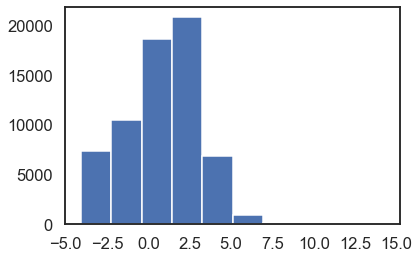

Max Minutes Log: 14.304459829752572


In [80]:
# Maybe We Can Drop The Outliers
plt.hist(df['minutes_log'], bins=10)
plt.xticks(np.arange(-5, 17.5, 2.5))
plt.show()
print('Max Minutes Log:', df['minutes_log'].max() )

In [81]:
# Extracting month and month name from the month column
df["month"] = df["sighting_date"].apply(lambda x: x.month)
df['month_name'] = df['month'].apply(lambda x: calendar.month_name[x])

# Extracting the year from the date column
df["year"] = df["sighting_date"].apply(lambda x: x.year)

# All three columns
print(df[['sighting_date', 'month', 'month_name', 'year']].head(3))
print(df.shape)

  sighting_date  month month_name  year
1    1949-10-10     10    October  1949
2    1949-10-10     10    October  1949
3    1955-10-10     10    October  1955
(80332, 17)


# Countries and City Columns

In [82]:
# Missing A Lot Of Countries Filled With 'Unspecified'
df['country'].value_counts()

us             65114
unspecified     9670
ca              3000
gb              1905
au               538
de               105
Name: country, dtype: int64

In [83]:
# Less Missing For States 
df['state'].value_counts()

ca             9655
unspecified    5797
wa             4268
fl             4200
tx             3677
               ... 
nf               25
nt               20
pe               17
yt               13
yk                7
Name: state, Length: 68, dtype: int64

In [84]:
# Setting Region Boundries With Google Maps Coordinates. 
# These Are Broad Continent/Regions and will be added to the 'Countries' Column

conditions = [ 
#aus
(df['lat'] > -48.0) & (df['lat'] <-7.0) & (df['long'] > -171.0) & (df['lat'] < 104.0)
    & (df['lat'] != -0) & (df['long'] != -0), 
#africa                                                                                        
(df['lat'] > -37.0) & (df['lat'] <37.0) & (df['long'] > -26.0) & (df['lat'] < 48.0)
    & (df['lat'] != -0) & (df['long'] != -0),
#mideast
(df['lat'] >10.0) & (df['lat'] <47.0) & (df['long'] > 35.0) & (df['lat'] < 90.0)
    & (df['lat'] != 0) & (df['long'] != 0),
#latam
(df['lat'] >-59.0) & (df['lat'] <30.0) & (df['long'] < -29.0) & (df['lat'] >-126.0)
    & (df['lat'] != -0) & (df['long'] != -0)]


                                                                                       

categories = ['aus-nz', 'africa', 'mideast', 'latam']

df['added_countries'] = np.select(conditions, categories)
df['added_countries'] = df['added_countries'].str.replace('0','')
df['country'] = df['country'] + df['added_countries']
df['added_countries'].value_counts()

           73619
latam       4984
aus-nz       924
africa       763
mideast       42
Name: added_countries, dtype: int64

In [85]:
df = df.drop('added_countries', axis=1)

In [86]:
# Mapping new regions and combining with existing regions
df['country'] = df['country'].map({'unspecifiedafrica':'africa', 'unspecifiedlatam ': 'latam',
                                  'unspecifiedaus-nz':'aus-nz', 'auaus-nz': 'aus-nz', "au":'aus-nz',
                                  'unspecifiedmideast':'mideast', 'uslatam': 'latam', 'gb':'uk-irl',
                                  'ca':'ca', 'de':'de', 'us':'us', 'unspecified':'unspecified'})

df['country'] = df['country'].fillna('unspecified')
df['country'].value_counts()

us             60917
unspecified     8419
latam           4197
ca              3000
uk-irl          1905
aus-nz           984
africa           763
de               105
mideast           42
Name: country, dtype: int64

In [87]:
# Label Encoding The Country/Regions
le = LabelEncoder()

x = le.fit_transform(df['country'])

df['country_enc'] = x

In [88]:
df['state']

1                 tx
2                 tx
3        unspecified
4                 tx
5                 hi
            ...     
80328             tn
80329             id
80330             ca
80331             va
80332             ok
Name: state, Length: 80332, dtype: object

In [89]:
# Label Encoding The States
le = LabelEncoder()

y = le.fit_transform(df['state'])

df['state_enc'] = y

In [93]:
# Extracting Cities From A String Copied That I Copied From Google
with open('dataset/country_list.txt') as f:
    lines = f.readlines()
lines = [x.strip() for x in lines]
lines = [x.lower() for x in lines]
lines[:2]

['afghanistan', 'albania']

In [94]:
# Extracting The List and Filling NaNs' with 'Unspecified'
df['added_region'] = df['city'].str.findall(f'({"|".join(lines)})')
df['added_region'] = df['city'].str.extract(f'({"|".join(lines)})')
df['added_region'] = df['added_region'].fillna('unspecified')
df['added_region'].value_counts()

unspecified    72970
canada          3589
australia        634
india            440
mexico           275
               ...  
tanzania           1
libya              1
moldova            1
paraguay           1
san marino         1
Name: added_region, Length: 132, dtype: int64

In [95]:
# Label Encoding The Added Cities
le = LabelEncoder()

x = le.fit_transform(df['added_region'])

df['city_enc'] = x

# Sighting Time of Day and Shapes

In [96]:
# Creating Time Of Day Column
df.loc[(df['time'] >=600) & (df['time'] <= 1200), 'sighting_time'] = 'morning'+'\n'+'(6am-12pm)'
df.loc[(df['time'] >=1200) & (df['time'] <=  1600), 'sighting_time'] = 'afternoon'+'\n'+'(12pm-4pm)'
df.loc[(df['time'] >=1600) & (df['time'] <=  2100), 'sighting_time'] = 'evening'+'\n'+'(4pm-9pm)'
df.loc[(df['time'] >=2100) & (df['time'] <=  2400), 'sighting_time'] = 'nighttime'+'\n'+'(9pm-12am)'
df.loc[(df['time'] >=0) & (df['time'] <=  600), 'sighting_time'] = 'latenight'+'\n'+'(12am-6am)'

In [97]:
# Encoding sighting_time 
def sighting(val):
    if val == 'morning'+'\n'+'(6am-12pm)':
        return 1
    elif val == 'afternoon'+'\n'+'(12pm-4pm)':
        return 2
    elif val =='evening'+'\n'+'(4pm-9pm)':
        return 3
    elif val== 'nighttime'+'\n'+'(9pm-12am)':
        return 4
    else:
        return 5

df['sighting_time_enc'] = df['sighting_time'].apply(sighting)

In [98]:
# Unique shape sighting count
print(df['shape'].value_counts())
# Number Of Shapes
print('\n'+'Number Of Shapes =', len(df['shape'].unique()))

light          16565
triangle        7865
circle          7608
fireball        6208
other           5649
unknown         5584
sphere          5387
disk            5213
oval            3733
formation       2457
cigar           2057
changing        1962
unspecified     1932
flash           1328
rectangle       1297
cylinder        1283
diamond         1178
chevron          952
egg              759
teardrop         750
cone             316
cross            233
delta              7
crescent           2
round              2
dome               1
changed            1
pyramid            1
flare              1
hexagon            1
Name: shape, dtype: int64

Number Of Shapes = 30


In [99]:
# OHE the ufo shapes
shape_set = pd.get_dummies(df['shape'])

# Concatenating OHE Values to the df 
df = pd.concat([df, shape_set], axis=1)
df.shape

(80332, 53)

# Visual EDA Of Cleaned Dataframe

In [100]:
# Smoother More Legible Plotting Style
sns.set(style="white", context="talk")

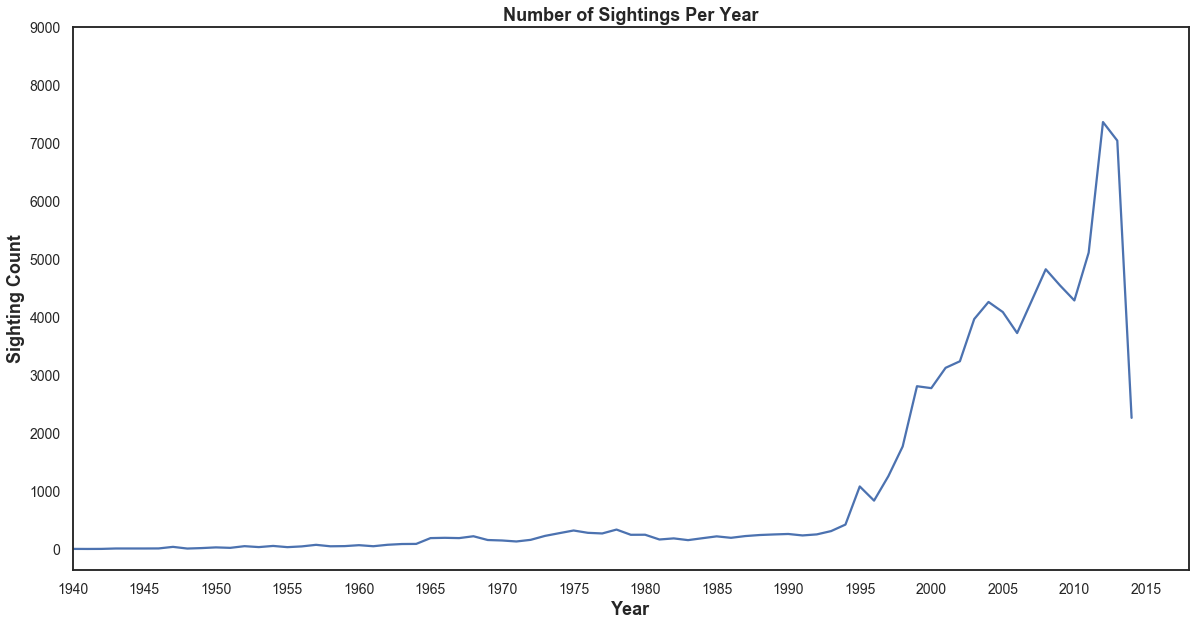

In [101]:
# Plotting Sighting Over Time (Since 1940)
plt.figure(figsize=(20,10))

sns.lineplot(data=df['year'].value_counts())

plt.xlim(1940, 2018)
plt.xticks(range(1940,2020, 5), rotation=0, size=14)
plt.yticks(range(0,10000, 1000), rotation=0, size=14)

plt.xlabel('Year', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('Number of Sightings Per Year', fontweight='semibold')
plt.show()

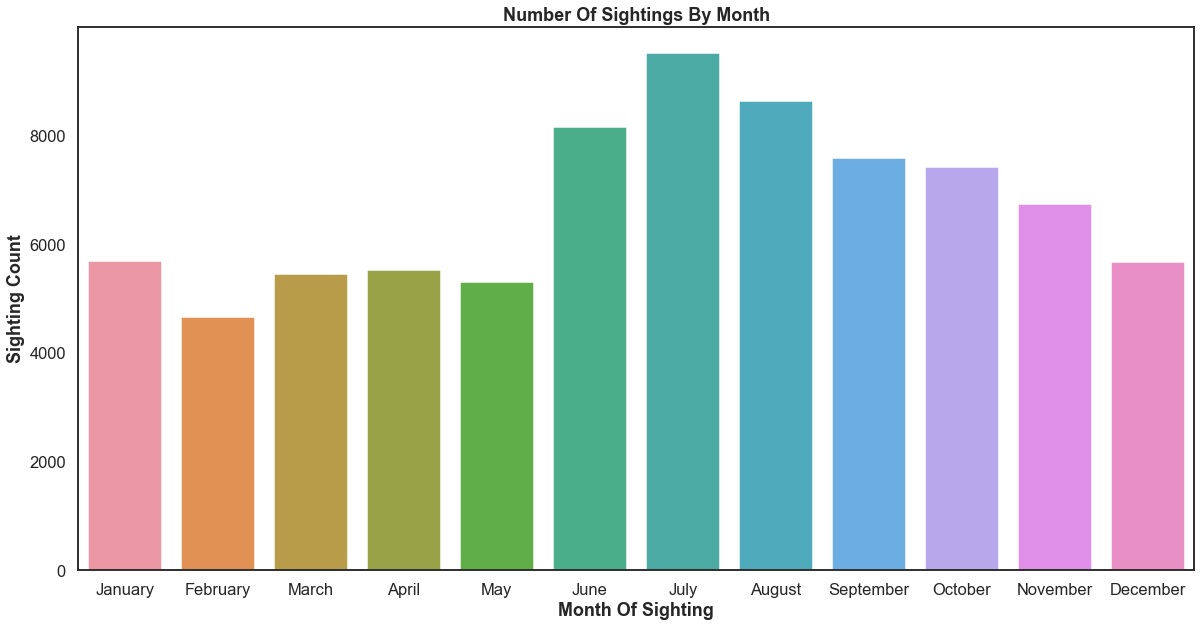

In [102]:
# Number Of Sightings By Month
plt.figure(figsize=(20,10))
sns.countplot(data=df.sort_values(by='month'),x='month_name')
plt.xlabel('Month Of Sighting', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('Number Of Sightings By Month', fontweight='semibold')
plt.show()

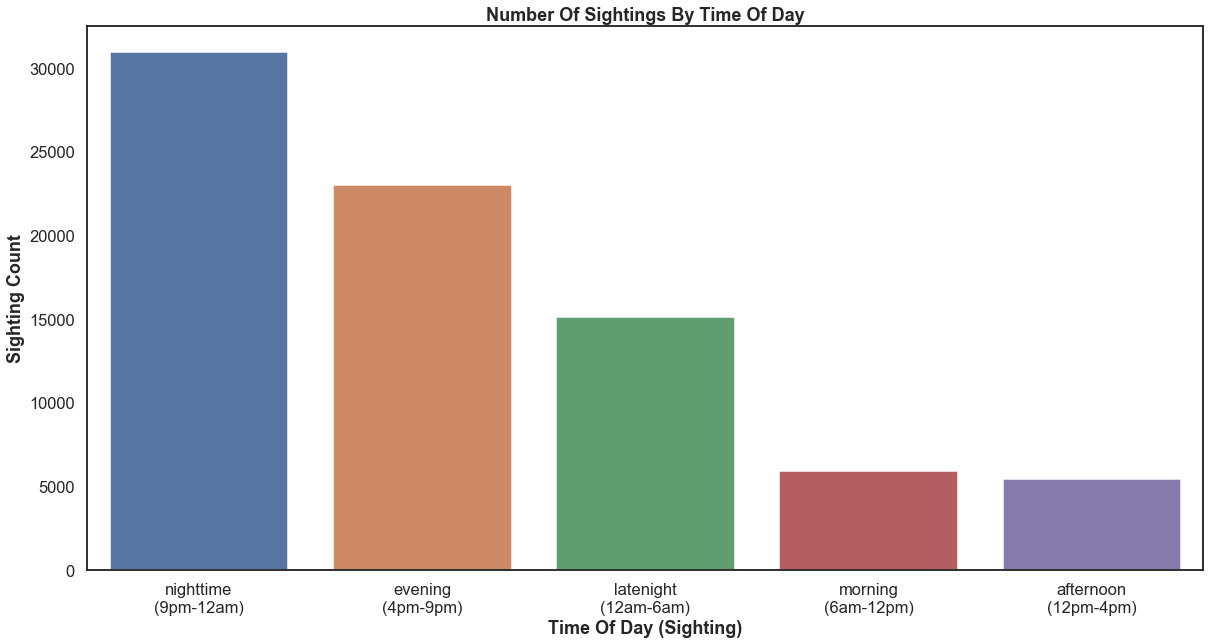

In [103]:
# Number Of Sightings By Time Of Day
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='sighting_time', 
              order=df['sighting_time'].value_counts().index)
plt.xlabel('Time Of Day (Sighting)', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('Number Of Sightings By Time Of Day', fontweight='semibold')
plt.show()

In [104]:
# Make The Upcoming Labels Easier To Read, Some I will Set To Upper After Grouping
df['state'] = df['state'].apply(lambda x: x.upper())
df['city'] = df['city'].apply(lambda x: x.upper())
df['country'] = df['country'].apply(lambda x: x.upper())

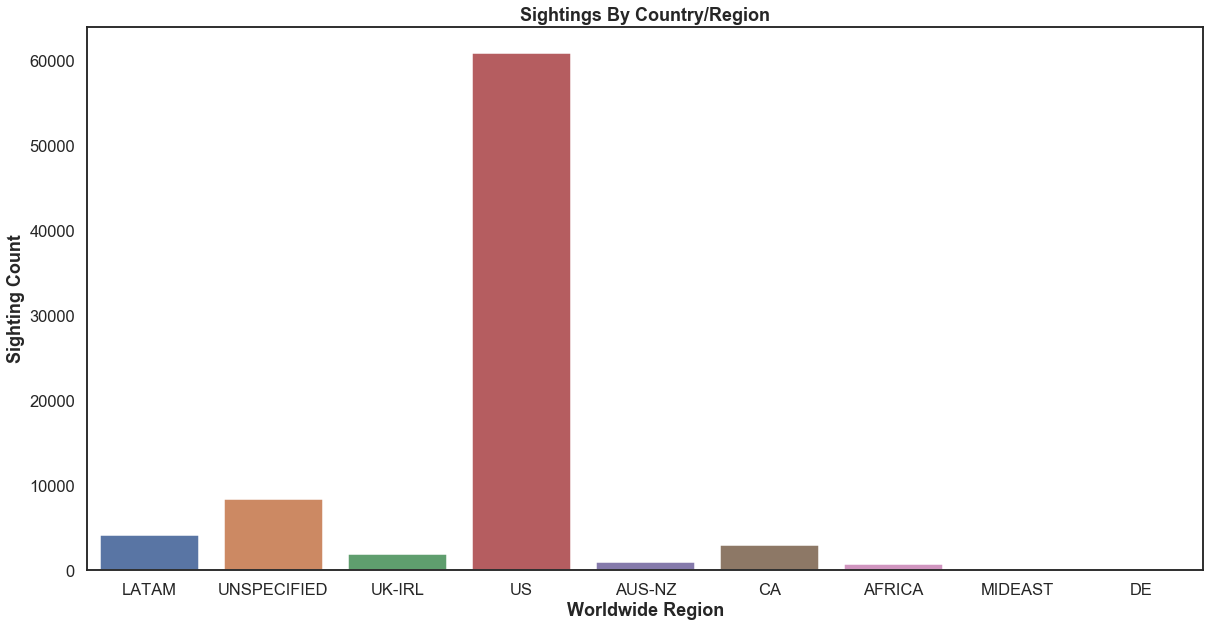

In [105]:
# Sightings By Country/Region
plt.figure(figsize=(20,10))
sns.countplot(data=df, x='country')
plt.xlabel('Worldwide Region', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('Sightings By Country/Region', fontweight='semibold')
plt.show()

In [106]:
# Group By States With Over 1000 Sighting AKA Hotspots
by_state = (df
    .groupby('state')
    .filter(lambda x: len(x) > 1000))

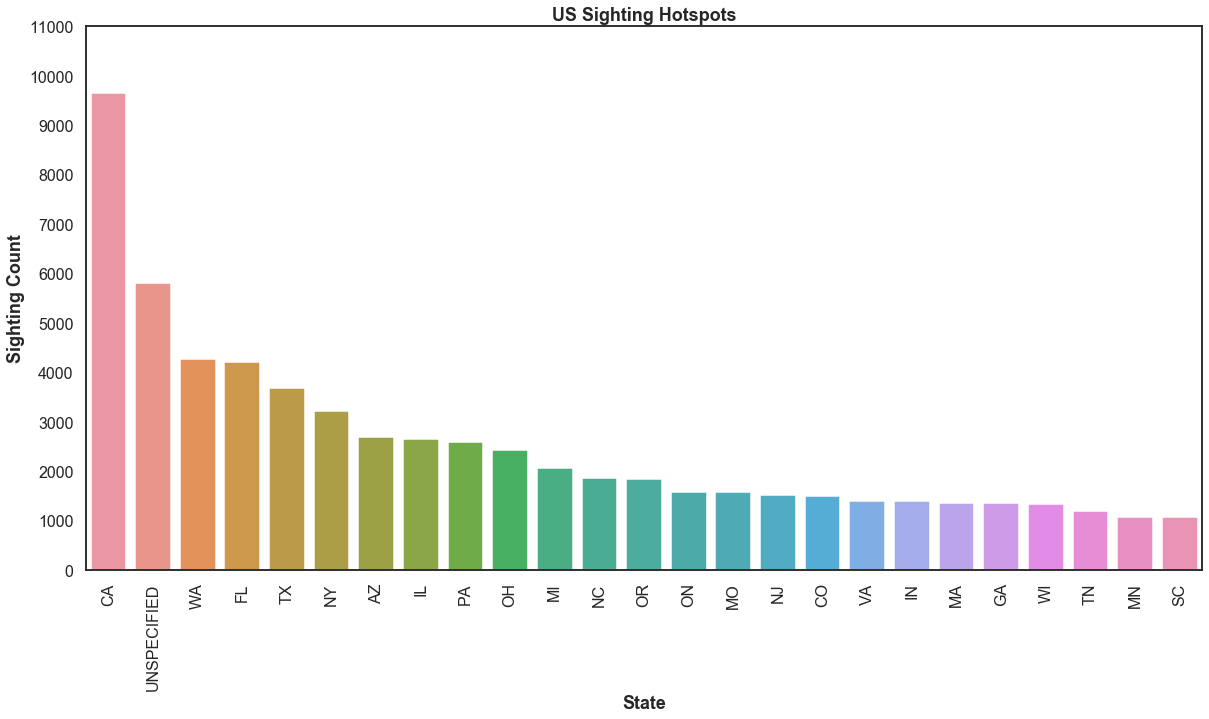

In [107]:
# Sighting By State Hotspots
plt.figure(figsize=(20,10))
sns.countplot(x = 'state',
              data = by_state,
              order = by_state['state'].value_counts().index)

plt.xticks(size=16, rotation=90)
plt.yticks(range(0,12000,1000),size=16, rotation=0)
plt.xlabel('State', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('US Sighting Hotspots', fontweight='semibold')
plt.show()

In [108]:
# Grouping Cities With Over 200 Sighting
by_city = (df
    .groupby('city')
    .filter(lambda x: len(x) > 200))

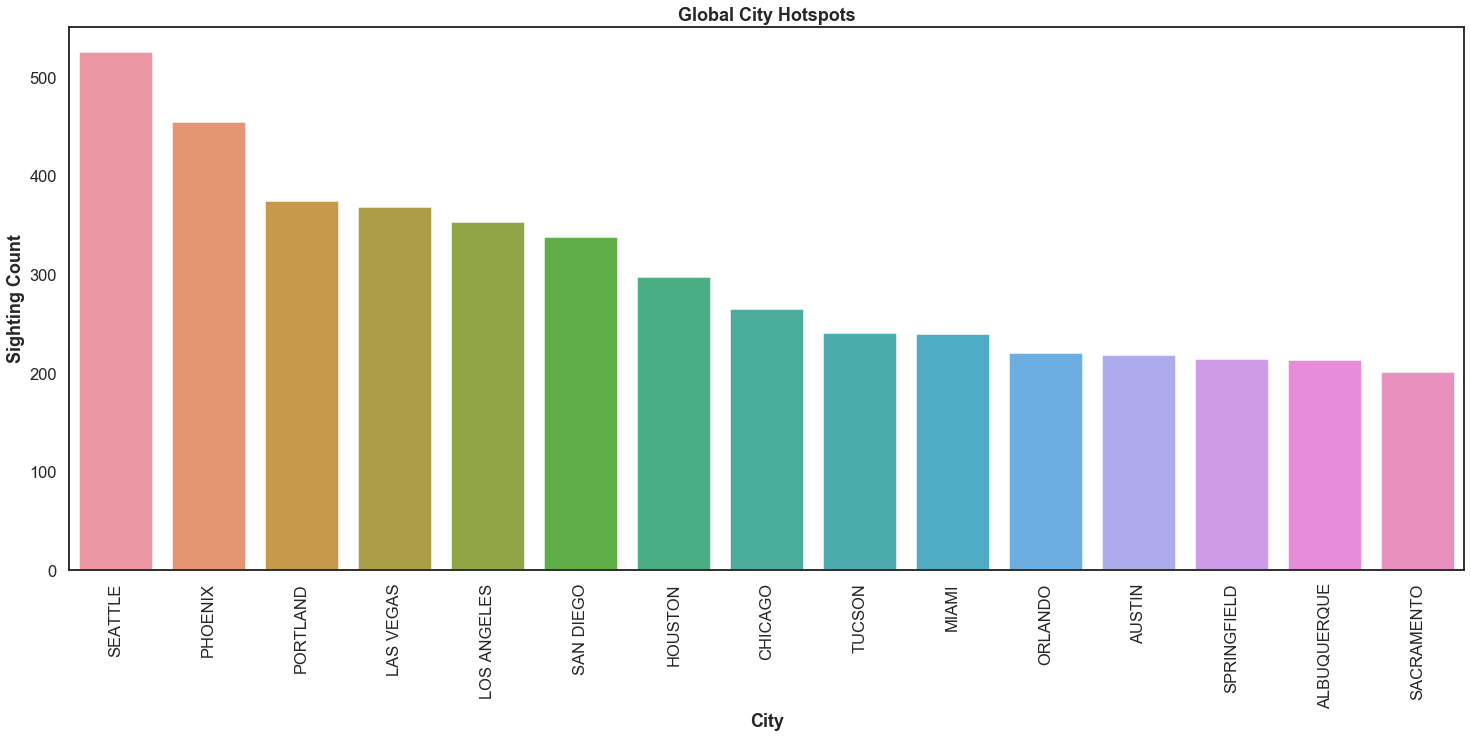

In [109]:
# Sighting By Global City Hotspot
plt.figure(figsize=(25,10))
sns.countplot(x = 'city',
              data = by_city,
              order = by_city['city'].value_counts().index)
plt.xlabel('City', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('Global City Hotspots', fontweight='semibold')
plt.xticks(rotation=90)
plt.show()

In [110]:
# Groupby Count Transforming Data To Heatmap Compatable Count Of Shapes Per Cities
shape_by_city = (df
    .groupby('city')
    .filter(lambda x: len(x) > 100) 
    .groupby(['shape', 'city'])
    .size()
    .unstack())

# Make The Shapes More Legible
shape_by_city.index = shape_by_city.index.str.upper()

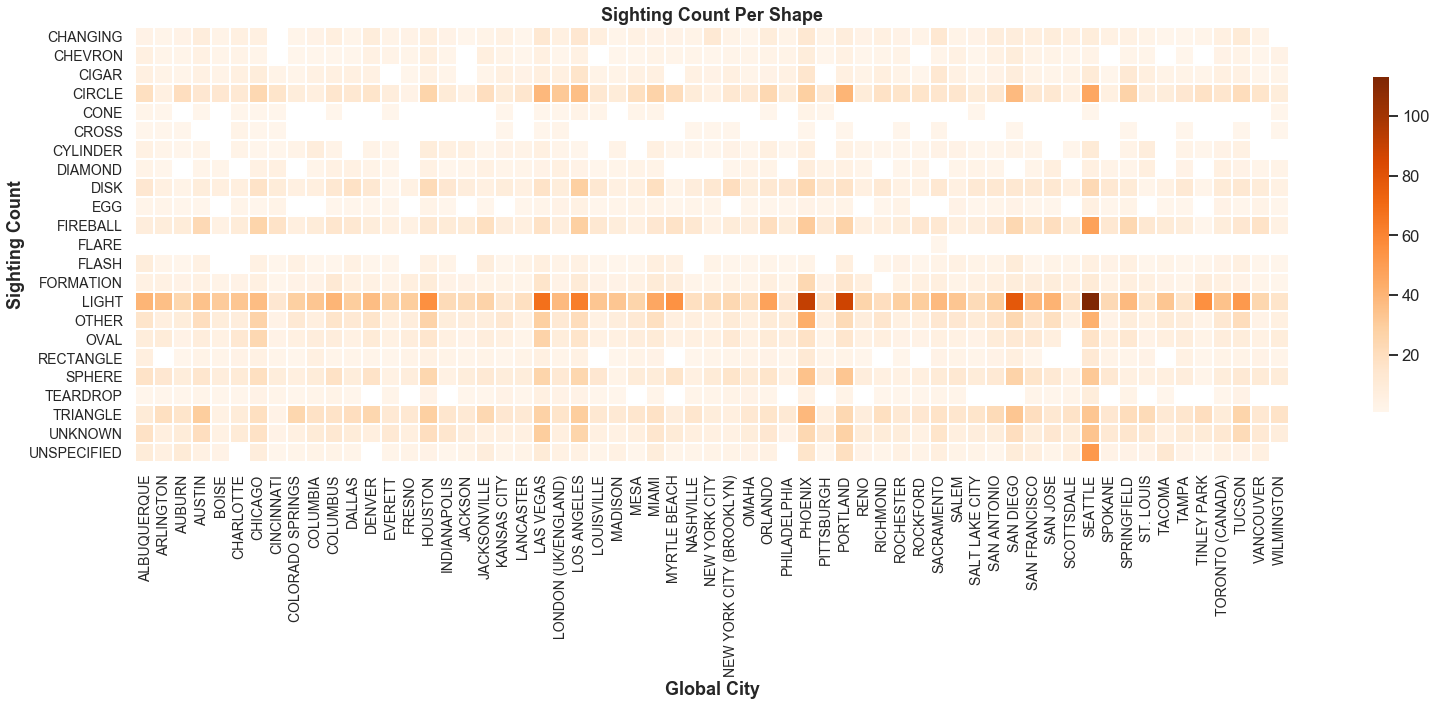

In [111]:
# Shape By City Hotspot
plt.figure(figsize=(30,8))
heat = sns.heatmap(
        shape_by_city,
        square=True,
        cbar_kws= {'fraction': 0.01},
        cmap='Oranges',
        linewidth=1
)
heat.set_xticklabels(heat.get_xticklabels(), fontsize=14, rotation=90,horizontalalignment='center')
heat.set_yticklabels(heat.get_yticklabels(), fontsize=14, rotation=0)
plt.xlabel('Global City', fontweight='semibold')
plt.ylabel('Sighting Count', fontweight='semibold')
plt.title('Sighting Count Per Shape', fontweight='semibold')
plt.show()

In [112]:
shape_by_time = (df
    .groupby('shape')
    .filter(lambda x: len(x) > 1) # Filters Out European Sightings and Lower Activity US Cities
    .groupby(['sighting_time', 'shape'])
    .size()
    .unstack())
shape_by_time.index = shape_by_time.index.str.upper()
shape_by_time.columns = shape_by_time.columns.str.upper()

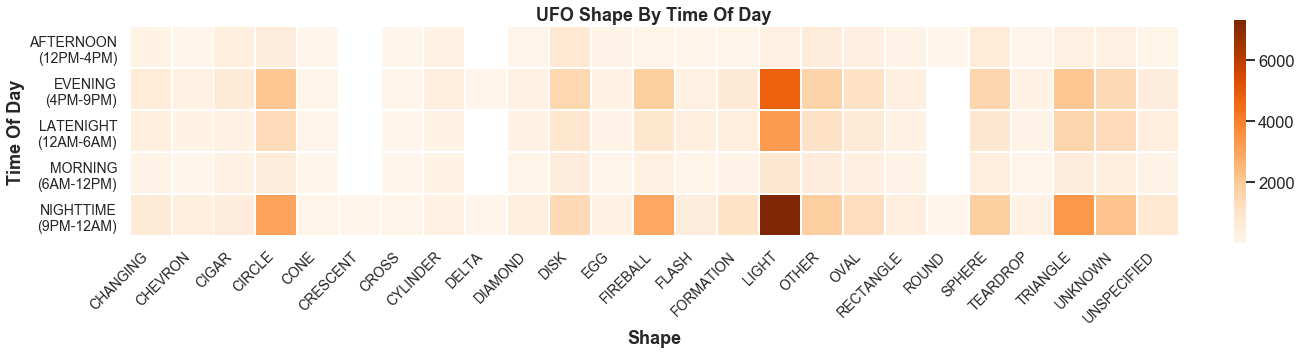

In [113]:
# Shape By Time Of Day 
plt.figure(figsize=(20,10))
heat = sns.heatmap(
        shape_by_time,
        square=True,
        cbar_kws= {'fraction': 0.01},
        cmap='Oranges',
        linewidth=1
)
heat.set_xticklabels(heat.get_xticklabels(), fontsize=14, rotation=45,horizontalalignment='right')
heat.set_yticklabels(heat.get_yticklabels(), fontsize=14, rotation=0,horizontalalignment='right')
plt.xlabel('Shape', fontweight='semibold')
plt.ylabel('Time Of Day', fontweight='semibold')
plt.title('UFO Shape By Time Of Day', fontweight='semibold')
plt.show()

In [114]:
shape_by_year = (df
    .groupby('shape')
    .filter(lambda x: len(x) > 1) # Filters Out European Sightings and Lower Activity US Cities
    .groupby(['shape', 'year'])
    .size()
    .unstack())
shape_by_year.index = shape_by_year.index.str.upper()

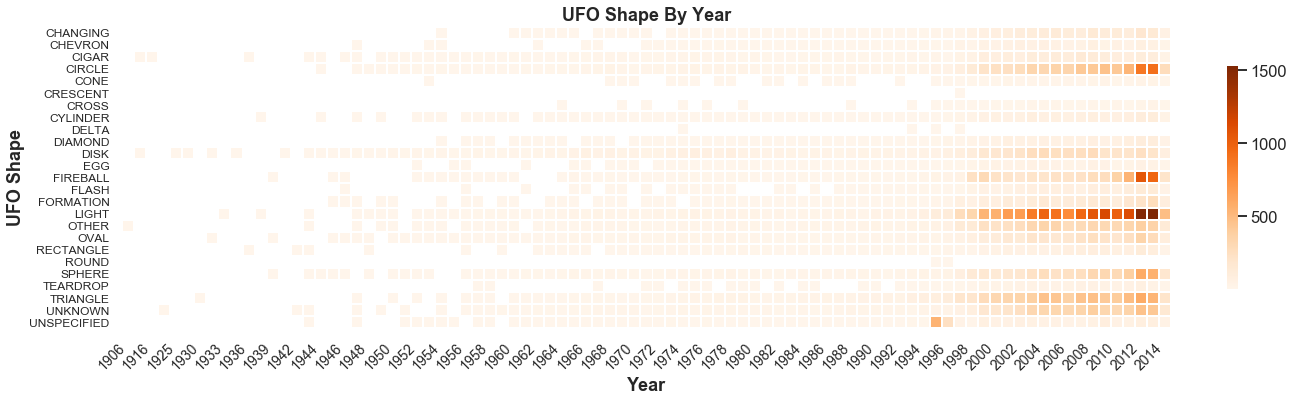

In [115]:
# Shape By Year 
plt.figure(figsize=(20,10))
heat = sns.heatmap(
        shape_by_year,
        square=True,
        cbar_kws= {'fraction': 0.01},
        cmap='Oranges',
        linewidth=1
)
heat.set_xticklabels(heat.get_xticklabels(), fontsize=14, rotation=45,horizontalalignment='right')
heat.set_yticklabels(heat.get_yticklabels(), fontsize=12, rotation=0)
plt.xlabel('Year', fontweight='semibold')
plt.ylabel('UFO Shape', fontweight='semibold')
plt.title('UFO Shape By Year', fontweight='semibold')
plt.show()

/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()


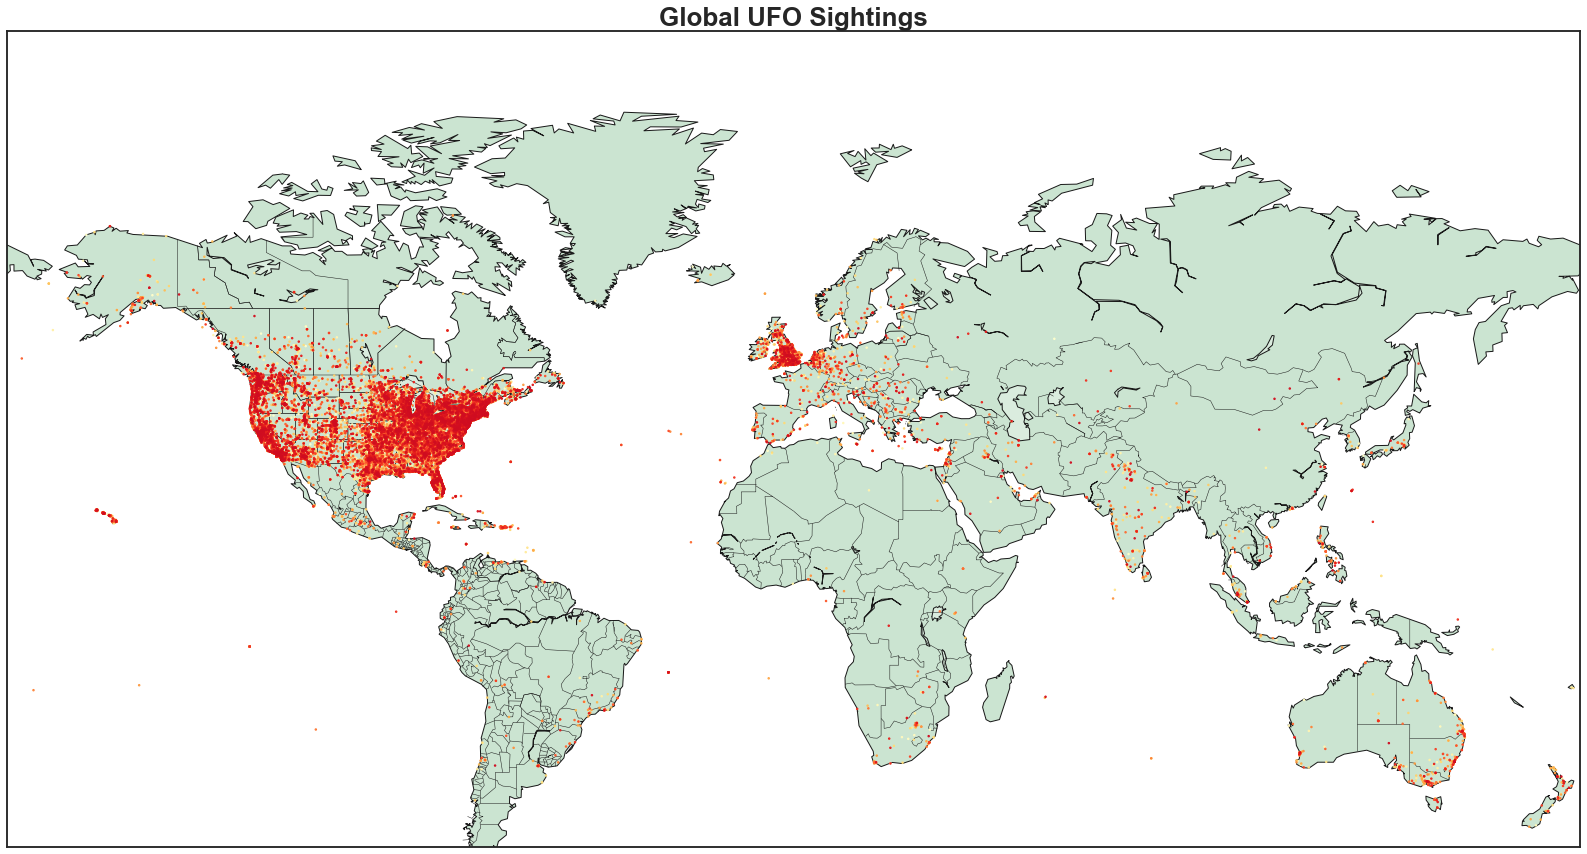

In [117]:
# Global Map Of UFO Sightings Using Lat Long
plt.figure(figsize=(30,15))
m = Basemap(projection='mill',
           llcrnrlat = -50,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')

m.drawstates()
m.drawcountries()
m.drawcoastlines()

lat, long = df['lat'].tolist(), df['long'].tolist()

t = np.arange(80332)

m.scatter(long, lat, marker = 'o', c=t, cmap='YlOrRd', s=1, zorder=10, latlon=True)
m.fillcontinents(color='g', alpha =0.3)

plt.title("Global UFO Sightings", fontsize=26, fontweight='semibold')

plt.show()

# -------------------------Final Checks For ML Modelling----------------------------

In [118]:
df.head()

,datetime,city,state,country,shape,seconds,minutes,comments,date added,lat,long,sighting_date,time,minutes_log,month,month_name,year,country_enc,state_enc,sighting_time,added_region,city_enc,sighting_time_enc,changed,changing,chevron,cigar,circle,cone,crescent,cross,cylinder,delta,diamond,disk,dome,egg,fireball,flare,flash,formation,hexagon,light,other,oval,pyramid,rectangle,round,sphere,teardrop,triangle,unknown,unspecified
1,10/10/1949 20:30,SAN MARCOS,TX,LATAM,cylinder,2700.0,45.000000,This event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,1949-10-10,2030,3.806662,10,October,1949,4,57,evening\n(4pm-9pm),unspecified,126,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10/10/1949 21:00,LACKLAND AFB,TX,UNSPECIFIED,light,7200.0,120.000000,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.384210,-98.581082,1949-10-10,2100,4.787492,10,October,1949,7,57,nighttime\n(9pm-12am),unspecified,126,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,10/10/1955 17:00,CHESTER (UK/ENGLAND),UNSPECIFIED,UK-IRL,circle,20.0,0.333333,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.200000,-2.916667,1955-10-10,1700,-1.098612,10,October,1955,6,58,evening\n(4pm-9pm),unspecified,126,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10/10/1956 21:00,EDNA,TX,LATAM,circle,20.0,0.333333,My older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,1956-10-10,2100,-1.098612,10,October,1956,4,57,nighttime\n(9pm-12am),unspecified,126,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,10/10/1960 20:00,KANEOHE,HI,LATAM,light,900.0,15.000000,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.418056,-157.803611,1960-10-10,2000,2.708050,10,October,1960,4,13,evening\n(4pm-9pm),unspecified,126,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [119]:
df.dtypes

datetime                     object
city                         object
state                        object
country                      object
shape                        object
seconds                     float64
minutes                     float64
comments                     object
date added                   object
lat                         float64
long                        float64
sighting_date        datetime64[ns]
time                          int64
minutes_log                 float64
month                         int64
month_name                   object
year                          int64
country_enc                   int64
state_enc                     int64
sighting_time                object
added_region                 object
city_enc                      int64
sighting_time_enc             int64
changed                       uint8
changing                      uint8
chevron                       uint8
cigar                         uint8
circle                      

In [121]:
# Dropping Columns That Have Converted/Encoded Copies
no_nan_df = df.drop(['datetime', 'seconds', 'state', 'city', 'minutes','country', 'shape','comments',
              'date added','month_name', 'added_region','sighting_time','sighting_date'],axis=1)

In [122]:
# Check For High Variance 
no_nan_df.var()

lat                     115.426400
long                   1575.868057
time                 587248.727818
minutes_log               4.739148
month                    10.464336
year                    108.718820
country_enc               3.055317
state_enc               431.879194
city_enc                710.934175
sighting_time_enc         1.198221
changed                   0.000012
changing                  0.023827
chevron                   0.011711
cigar                     0.024951
circle                    0.085739
cone                      0.003918
crescent                  0.000025
cross                     0.002892
cylinder                  0.015716
delta                     0.000087
diamond                   0.014449
disk                      0.060683
dome                      0.000012
egg                       0.009359
fireball                  0.071308
flare                     0.000012
flash                     0.016258
formation                 0.029650
hexagon             

In [123]:
# Check For Remaining NaNs
df.isna().sum()

datetime                 0
city                     0
state                    0
country                  0
shape                    0
seconds              14797
minutes              14797
comments                 0
date added               0
lat                  14797
long                     0
sighting_date            0
time                     0
minutes_log          14797
month                    0
month_name               0
year                     0
country_enc              0
state_enc                0
sighting_time            0
added_region             0
city_enc                 0
sighting_time_enc        0
changed                  0
changing                 0
chevron                  0
cigar                    0
circle                   0
cone                     0
crescent                 0
cross                    0
cylinder                 0
delta                    0
diamond                  0
disk                     0
dome                     0
egg                      0
f

# ----------------------------Predict Latitiude To Insert To DF--------------------------

In [124]:
# Dropping NaN LAtitudes before Creating Dtype Masks (Will Attempt To Model Missing Lats Later)
no_nan_df = no_nan_df.dropna()

In [125]:
X, y = no_nan_df.drop('lat', axis=1), no_nan_df['lat']

# Split the X and y sets using train_test_split, setting stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

print(X_train.shape)
print(X_test.shape)

(49151, 39)
(16384, 39)


In [126]:
clf_r = xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.01, learning_rate = 1,
                max_depth = 50, alpha = 0.1, n_estimators = 100)

In [127]:
# Basic Tuned XGBClassifier (No SearchCV Performed)
clf_r = xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 1,
                max_depth = 50, alpha = 0.1, n_estimators = 100)


clf_r.fit(X_train,y_train)

preds = clf_r.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Test Set RMSE: %f" % (rmse))

Test Set RMSE: 1.716473


# ----------------------Regression Model Sighting Time -----------------------------

In [128]:
minutes_agg = df['minutes_log'].agg([min, np.median, np.mean, max, np.std])
minutes_agg

min       -4.094345
median     1.098612
mean       0.854611
max       14.304460
std        2.176958
Name: minutes_log, dtype: float64

In [129]:
# Creating Numeric X, y Vairables
X, y = no_nan_df.drop(
    ['minutes_log', 'lat', 'long'],axis=1),no_nan_df['minutes_log']


# Split the X and y sets using train_test_split, setting stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

print(X_train.shape)
print(X_test.shape)

(49151, 37)
(16384, 37)


In [130]:
# Basic Tuned XGBRegressor (No SearchCV Performed)
clf_r = xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.01, learning_rate = 1,
                max_depth = 50, alpha = 0.1, n_estimators = 100)


clf_r.fit(X_train,y_train)

preds = clf_r.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Test Set RMSE: %f" % (rmse))

Test Set RMSE: 2.151537


In [131]:
# Cross Validating The Results
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":'reg:squarederror','colsample_bytree': 0.9,'learning_rate': 0.7,
                'max_depth': 5, 'alpha': 0.1}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.153884,0.002216,2.159371,0.005062
1,2.132978,0.003433,2.142961,0.004122
2,2.123273,0.002518,2.138229,0.004599
3,2.117706,0.003320,2.136850,0.004973
4,2.111064,0.004157,2.134588,0.004696


# -----------------Classifying Region Of Sighting (Region, Lat, Long)----------------

In [132]:
no_nan_df.head(2)

,lat,long,time,minutes_log,month,year,country_enc,state_enc,city_enc,sighting_time_enc,changed,changing,chevron,cigar,circle,cone,crescent,cross,cylinder,delta,diamond,disk,dome,egg,fireball,flare,flash,formation,hexagon,light,other,oval,pyramid,rectangle,round,sphere,teardrop,triangle,unknown,unspecified
1,29.883056,-97.941111,2030,3.806662,10,1949,4,57,126,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29.384210,-98.581082,2100,4.787492,10,1949,7,57,126,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [133]:
# Creating Numeric X, y Vairables
X, y = no_nan_df.drop(
    ['country_enc','lat','long'],
    axis=1),no_nan_df['country_enc']

# Split the X and y sets using train_test_split, setting stratify=y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

print(X_train.shape)
print(X_test.shape)

(49151, 37)
(16384, 37)


In [134]:
# Tuned XGboost Classifier (Tuned With Random Search Below)
clf_c = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, n_estimators=50, n_jobs=0, num_parallel_tree=2,
              objective='multi:softprob', random_state=123, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1) 


clf_c.fit(X_train, y_train)

# Test and Training Set Acurracy Score
accuracy_train = accuracy_score(y_train, clf_c.predict(X_train))
accuracy_test = accuracy_score(y_test, clf_c.predict(X_test))
print("{0:.1%} accuracy on test set vs. {1:.1%} on training set".format(accuracy_test, accuracy_train))

88.5% accuracy on test set vs. 88.4% on training set


In [135]:
# Further Assessing Accuracy Across Classes
y_pred = clf_c.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.71      0.77       201
           1       0.96      0.89      0.93       237
           2       0.85      1.00      0.92       584
           3       0.84      0.96      0.90        28
           4       0.81      0.74      0.78      1060
           5       0.00      0.00      0.00        10
           6       0.68      0.99      0.81       386
           7       0.85      0.14      0.24      1652
           8       0.90      0.99      0.94     12226

    accuracy                           0.88     16384
   macro avg       0.75      0.71      0.70     16384
weighted avg       0.88      0.88      0.85     16384



/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
kfold = KFold(n_splits=10)
results = cross_val_score(clf_c, X, y, cv=kfold)
print("Mean Accuracy: %.2f%%, Standard Deviation (%.2f%%)" % (results.mean()*100, results.std()*100))

Mean Accuracy: 88.29%, Standard Deviation (0.60%)


In [137]:
# # # Running A GridSearchCV To Find More Optimal Parameters
# xgb_param_grid = {
#     'learning_rate': np.arange(0.05, 1, 0.05),
#     'max_depth': np.arange(5, 12, 2),
#     'n_estimators': np.arange(0, 100, 50),
#     'gamma': np.arange(0, 1, 0.1),
#     'colsample_bylevel': np.arange(0, 1, 0.1)
# }
    
# rndm_xgb = RandomizedSearchCV(estimator=clf_c, param_distributions=xgb_param_grid, verbose=2, 
#                              scoring='precision_weighted', cv=3, n_jobs=3)

# rndm_xgb.fit(X, y)

# # Computing Param metrics
# print('Best precision_weighted: %.2f'% rndm_xgb.best_score_)
# print('Best Params:',rndm_xgb.best_estimator_)